# Cutting planes enhanced by GCN models and Q-learning for branching

In [ ]:
!pip install dgl

In [ ]:
!pip install pulp

In [ ]:
import numpy as np
import pandas as pd 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as th

from copy import deepcopy
from datetime import datetime
import random 
from collections import deque
from dgl import DGLGraph
import seaborn as sns
import matplotlib.pyplot as plt 
import networkx as nx
from sklearn.manifold import TSNE
from google.colab import files

Using backend: pytorch
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# mijn functions
import actions_v12 as act
import graph_models_v17 as gm

Valid inequalities version: 9
No hard restrictions for teeth assignments


**Champion GCN models**

In [ ]:
# Models
GCN1 = gm.GCN5_MN(4, 256, 8, 0.2)
GCN1.load_state_dict(th.load("GCN1_JUN3.pth.tar"))
GCN1.eval()

GCN2 = gm.GCN5_MX(4, 256, 8, 0.2)
GCN2.load_state_dict(th.load("GCN2_JUN3.pth.tar"))
GCN2.eval()

GCN3 = gm.GCN5_SU(4, 256, 8, 0.2)
GCN3.load_state_dict(th.load("GCN3_JUN3.pth.tar"))
GCN3.eval()

GAT1 = gm.GAT3_MN(4, 16, 8, 8, 0.2)
GAT1.load_state_dict(th.load("GAT1_JUN4.pth.tar"))
GAT1.eval()

GAT2 = gm.GAT3_MX(4, 16, 8, 8, 0.2)
GAT2.load_state_dict(th.load("GAT2_JUN4.pth.tar"))
GAT2.eval()

GAT3 = gm.GAT3_SU(4, 16, 8, 8, 0.2)
GAT3.load_state_dict(th.load("GAT3_JUN4.pth.tar"))
GAT3.eval()

# Thresholds
# 0,1,2,3,4,5,7,8
tholds = [0.449, 0.343, 0.377, 0.274, 0.593, 0.336, 0.261, 0.223]

**Take actions**

In [ ]:
def pick_actions(problem, tholds, model1, model2, model3, verbose):

    # 0: subtour elimination
    # 1: blossoms (basic combs)
    # 2: advanced comb
    # 3: clique tree
    # 4: blossom + path 
    # 5: bipartition
    # 6: envelope (NOT APPLICABLE)
    # 7: crown 8 
    # 8: crown multiple 
    
    graph1 = problem.graph 
    graph1.add_edges_from(zip(graph1.nodes(), graph1.nodes()))
    graph1 = DGLGraph(graph1)

    pred1, g_emb1, n_emb1 = model1(graph1)
    pred2, g_emb2, n_emb2 = model2(graph1)
    pred3, g_emb3, n_emb3 = model3(graph1)

    counter0 = 0 
    counter1 = 0 
    counter2 = 0 
    counter3 = 0 
    counter4 = 0 
    counter5 = 0 
    counter7 = 0 
    counter8 = 0 
    cycle_cutoff = 0.99 
    teeth_cutoff = 0.1
    teeth_cutoff_path = 1
    connection_check_flag = 1 # set this as 1 in order to avoid redundant constraints 
    false_alarm = 0
    true_alarm = 0

    # 0: subtour elimination (GCN1 - GCN3)
    action0 = 1 if (pred1[0][0].detach().item() + pred3[0][0].detach().item())/2 >= tholds[0] else 0 
    if action0 == 1: # go find isolated islands and add subtours 
        counter0 = problem.subtour_elimn()
        if counter0 > 0:
          true_alarm = true_alarm + 1
          if verbose == 1:
            print('yes, there were subtours indeed:', counter0)
        else: 
          false_alarm = false_alarm + 1
          if verbose == 1:
            print('nope, there were NO subtours, wrong prediction')

    # 1: basic blossom inequalities (GCN3)
    action1 = 1 if pred3[0][1].detach().item() >= tholds[1] else 0 
    if action1 == 1:
        counter1 = problem.find_multi_blossoms(cycle_cutoff, teeth_cutoff)
        if counter1 > 0:
          true_alarm = true_alarm + 1
          if verbose == 1:
            print('yes, there were blossoms indeed:', counter1)
        else: 
          false_alarm = false_alarm + 1
          if verbose == 1:
            print('nope, there were NO blossoms, wrong prediction')

    # 2: advanced comb inequalities (GCN3)
    action2 = 1 if pred3[0][2].detach().item() >= tholds[2] else 0 
    if action2 == 1: 
        counter2 = problem.find_adv_combs(cycle_cutoff, teeth_cutoff)
        if counter2 > 0:
          true_alarm = true_alarm + 1
          if verbose == 1:
            print('yes, there were advanced combs indeed:', counter2)
        else: 
          false_alarm = false_alarm + 1
          if verbose == 1:
            print('nope, there were NO advanced combs, wrong prediction')

    # 3: clique-tree inequality (GCN 1-2-3)
    action3 = 1 if (pred1[0][3].detach().item() + pred2[0][3].detach().item() + pred3[0][3].detach().item())/3 >= tholds[3] else 0 
    if action3 == 1: 
        counter3 = problem.find_clique_tree_2(cycle_cutoff, teeth_cutoff) 
        if counter3 > 0:
          counter3 = 1
          true_alarm = true_alarm + 1
          if verbose == 1:
            print('yes, there was a clique-tree indeed')
        else: 
          false_alarm = false_alarm + 1
          if verbose == 1:
            print('nope, there was NO clique-tree, wrong prediction')
        
    # 5: bipartiton inequality (GCN1 - GCN2)
    action5 = 1 if (pred1[0][5].detach().item() + pred2[0][5].detach().item())/2 >= tholds[5] else 0 
    if action5 == 1:
        counter5 = problem.find_bipartition(cycle_cutoff, teeth_cutoff) 
        if counter5 > 0:
          counter5 = 1
          true_alarm = true_alarm + 1
          if verbose == 1:
            print('yes, there was a bipartiton indeed')
        else: 
          false_alarm = false_alarm + 1
          if verbose == 1:
            print('nope, there was NO bipartition, wrong prediction')

    # 4: blossom and path inequality (GCN1 - GCN3)
    action4 = 1 if (pred1[0][4].detach().item() + pred3[0][4].detach().item())/2 >= tholds[4] else 0 
    if action4 == 1:
        counter4 = problem.find_blossom_n_path(cycle_cutoff, teeth_cutoff, teeth_cutoff_path) 
        if counter4 > 1:
          true_alarm = true_alarm + 1
          if verbose == 1:
            print('yes, there were blossom and following path indeed')
        elif counter4 == 1:
          true_alarm = true_alarm + 1
          if verbose == 1:
            print('hmm, there was only a blossom here')
        else: 
          false_alarm = false_alarm + 1
          if verbose == 1:
            print('nope, there were NO blossom and path, wrong prediction')

    # 7: crown with 8 subsets (GCN1 - GCN3)
    action7 = 1 if (pred1[0][6].detach().item() + pred3[0][6].detach().item())/2 >= tholds[6] else 0 
    if action7 == 1:
        counter7 = problem.find_crown_8(connection_check_flag)
        if counter7 > 1:
          true_alarm = true_alarm + 1
          counter7 = 1
          if verbose == 1:
            print('yes, there was a crown with 8 subsets indeed')
    
    # 8: crown with N subsets (GCN1 - GCN3)
    action8 = 1 if (pred1[0][7].detach().item() + pred3[0][7].detach().item())/2 >=  tholds[7] else 0 
    if action8 == 1: # go find advanced combs
        counter8 = problem.find_crown_more(connection_check_flag)
        if counter8 > 1:
          true_alarm = true_alarm + 1
          counter8 = 1
          if verbose == 1:
            print('yes, there was a crown with N subsets indeed')

    count_total = counter0 + counter1 + counter2 + counter3 + counter4 + counter5 + counter7 + counter8

    return problem, count_total, true_alarm, false_alarm

In [ ]:
def plot_graph(problem1):
    
    # load nodes
    graph = nx.Graph()
    graph.add_nodes_from(problem1.node_list)
    
    if len(problem1.X_soln) > 0:
      
        for k in range(len(problem1.X_soln)):
            graph.add_edge(problem1.X_soln.loc[k][0], problem1.X_soln.loc[k][1], capacity=1.0)
         
        problem1.X_soln['color'] = problem1.X_soln.apply(lambda x: 'b' if x.x_value >= 0.99  else 'r', axis=1)
        colors = problem1.X_soln['color'].to_list()
    
        #set coordinates and plot
        nx.set_node_attributes(graph, problem1.coordinates_dict, 'pos')    
        nx.draw(graph, nx.get_node_attributes(graph, 'pos'), with_labels = True, edge_color=colors)
        #plt.savefig("simple_path.png") 
        plt.show() 

**Qnet agent**

In [ ]:
class QTSP:
    def __init__(self, input_dim, output_dim, discount_rate, epochs):
        # initialize atributes
        self._input_size = input_dim
        self._action_size = output_dim
        self.discount_rate = discount_rate 
        self.epochs = epochs
        #self.loss_func = nn.MSELoss()
        
        # memory to keep state-action-reward-next state
        self.memo = deque(maxlen=50000)

        # build networks
        #WARNINGG
        self.q_network = self.build_compile_model() # q network to predict q values
        self.optimizer = optim.RMSprop(self.q_network.parameters())
        self.target_network = self.build_compile_model() # target network as frozen version of q network
        self.align_target_model() # align weights
        self.target_network.eval()
    
    def store(self, state, action, reward, next_state, complete_flag):
        self.memo.append((state, action, reward, next_state, complete_flag))
    
    def build_compile_model(self):
        model = gm.NNN_(self._input_size, self._action_size, 0.1)
        return model

    def align_target_model(self):
        # align weights
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def act(self, state, exploration_rate):
        if np.random.rand() <= exploration_rate:
            return random.randint(0, self._action_size-1)
        else:
            q_values = self.q_network(state) # predict state (graph)
            print('q_values are:', q_values.detach().numpy(), 'STATE LEN:', len(state))
            action1 = np.argmax(q_values.detach().numpy())
            print("this action is QMAX:", action1)
            return action1

    def retrain(self, batch_size, loss_list):
        minibatch = random.sample(self.memo, batch_size)
        print("training now")
        self.q_network.train()

        for epoch in range(self.epochs):
            for state, action, reward, next_state, complete_flag in minibatch:
                
                target = self.q_network(state)
        
                if complete_flag == 1:
                    target[action] = reward
                else:
                    # predict next state's q-value via target (2nd) network 
                    t = self.target_network(next_state)
                    target[action] = reward + self.discount_rate * np.amax(t.detach().numpy())
                
                prediction = self.q_network(state)
                loss = F.smooth_l1_loss(prediction, target)
                loss_list.append(loss.detach().numpy())
                self.optimizer.zero_grad() 
                loss.backward(retain_graph=True)
                self.optimizer.step()
        return loss_list 

In [ ]:
# weight initialization
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.02)

**Train/Test instances**

**TSP list**

In [ ]:
train_tsp_list = [

#(202,'TrainTSP4_4.csv'),
#(215,'TrainTSP4_17.csv'),

#(969,'TrainTSP20_0.csv'),
#(877,'TrainTSP17_32.csv'),
#(110,'TrainTSP2_10.csv'),
#(476,'TrainTSP9_28.csv'),

#(298,'TrainTSP6_0.csv'),
#(51,'TrainTSP1_1.csv'),
#(114,'TrainTSP2_14.csv'),
#(280,'TrainTSP5_32.csv'),
#(427,'TrainTSP8_29.csv'),

(1003,'Mega_graph_3.csv'),
(1001,'Mega_graph_1.csv'),
(1002,'Mega_graph_2.csv')
#(219,'TrainTSP4_21.csv'),
#(850,'TrainTSP17_5.csv'),
#(579,'TrainTSP11_31.csv'),

#(5,'TrainTSP0_5.csv'),
#(62,'TrainTSP1_12.csv'),
#(928,'TrainTSP18_33.csv'),
#(614,'TrainTSP12_18.csv'),
#(914,'TrainTSP18_19.csv'),
#(904,'TrainTSP18_9.csv'),
#(919,'TrainTSP18_24.csv'),
#(348,'TrainTSP7_0.csv')
]

# Cutting planes enhanced by GCN models

**Training TSPs**

In [ ]:
cutting_planes_train = pd.DataFrame()

In [ ]:
print('number of instances:', len(train_tsp_list))

number of instances: 22


In [ ]:
print('no need to run again')
#for k in range(len(train_tsp_list)): 

#  tsp_id = train_tsp_list[k][0]
#  data_name = train_tsp_list[k][1]
#  problem1 = act.init_prob(tsp_id, data_name, 0, 'continuous') 
#  initial_objective = problem1.objective_val
#  # show the initial solution
#  # plot_graph(problem1)
#  constraint_count = 0
#  true_alarm_count = 0
#  false_alarm_count = 0
#  con_limit = 500
#  change_flag = 1
#  start_time = datetime.now()
#  print("running for tsp:", tsp_id, "start time:", start_time)

#  while constraint_count <= con_limit and problem1.complete_flag == 0:
#    if change_flag == 0:
#      break 

#    else:
#      old_solution = problem1.X_soln[['origin', 'destination', 'x_value']]
#      problem1, count_total, true_alarm, false_alarm = pick_actions(problem1, tholds, GCN1, GCN2, GCN3, 0)

#      problem1.solve_lp_relax() 
#      new_solution = problem1.X_soln[['origin', 'destination', 'x_value']]
#      change_flag = 1 - int(old_solution.equals(new_solution))

#      if change_flag == 1:
#        
#        constraint_count = constraint_count + count_total 
#        true_alarm_count = true_alarm_count + true_alarm
#        false_alarm_count = false_alarm_count + false_alarm

#        problem1.graph = problem1.create_graph()
#        problem1.check_if_complete()

  
#  end_time = datetime.now()
#  # plot_graph(problem1)
#  problem1.check_if_complete()
#  if problem1.complete_flag == 0:
#    print('tour is NOT complete, branching needed!')
#  else: 
#    print('tour is complete!')
  
#  obj1 = {'tsp_id': tsp_id, 
#            'initial_objective': initial_objective, 
#            'final_objective' : problem1.objective_val, 
#            'start_time': start_time, 
#            'end_time': end_time, 
#            'complete_flag':problem1.complete_flag, 
#            'n_of_constraint': constraint_count, 
#            'true_alarm': true_alarm_count, 
#            'false_alarm': false_alarm_count,
#            'con_limit': con_limit
#          }
  
#  cutting_planes_train = cutting_planes_train.append(pd.DataFrame(obj1, index=[0]))

# download cutting planes output
#cutting_planes_train.to_csv('CP_train_perfo.csv')
#files.download('CP_train_perfo.csv') 

no need to run again


# Q-Network and Cutting Planes together

**Define the agent**

In [ ]:
action_size = 6
input_size = 128 * 2 + 256*2
batch_size = 64

loss_list = []

agent = QTSP(input_size, action_size, 0.99, 3) 

In [ ]:
agent.q_network.apply(init_weights)
agent.target_network.apply(init_weights)
MODEL_TAG = 'JUN18_1'

In [ ]:
agent.q_network.parameters

<bound method Module.parameters of NNN_(
  (layer1): Linear(in_features=768, out_features=768, bias=True)
  (drop_layer1): Dropout(p=0.1, inplace=False)
  (layer2): Linear(in_features=768, out_features=384, bias=True)
  (drop_layer2): Dropout(p=0.1, inplace=False)
  (layer3): Linear(in_features=384, out_features=192, bias=True)
  (drop_layer3): Dropout(p=0.1, inplace=False)
  (layer4): Linear(in_features=192, out_features=6, bias=True)
)>

**Load trained agent**

In [ ]:
agent.q_network.load_state_dict(th.load("GCN_QNET_JUN18.pth.tar"))
agent.target_network.load_state_dict(th.load("GCN_TARGETNET_JUN18.pth.tar"))

<All keys matched successfully>

**Functions for reward, branch-check and state**

In [ ]:
# reward calculation 
def calculate_reward(problem, initial_obj, prev_obj):
  
  last_obj = problem.objective_val
  #delta_obj1 = float(-1 if last_obj - prev_obj is None else last_obj - prev_obj)
  delta_obj2 = float(-1 if last_obj - initial_obj is None else abs(last_obj - initial_obj))

  # NEGATIVE REWARD PER BRANCH
  if problem.complete_flag == 0: 
    reward = 0
  #  if delta_obj1 > 0 and (delta_obj1/prev_obj) <= 1: 
  #    reward = -1 * (delta_obj1/prev_obj) + (-1)
  #  else:
  #    reward = -1.25
  else: 
    if delta_obj2 >= 0 and delta_obj2 < initial_obj:
      reward = round((1 - (delta_obj2/initial_obj)) * 10, 3)
    else:
      reward = -0.1
  
  return reward

def check_branch(problem):

  soln = problem.X_soln 
  fractional = soln[soln.x_value < 1]
  if len(fractional) > 0: 
    branch_flag = 1
  else:
    branch_flag = 0

  return branch_flag

# define state
def define_state(problem, model1, model2):
  
  graph1 = problem.graph 
  graph1.add_edges_from(zip(graph1.nodes(), graph1.nodes()))
  graph1 = DGLGraph(graph1)

  h = pd.DataFrame(graph1.in_degrees().detach().numpy()).reset_index(drop=False) 
  h = list(h[h[0] == h[0].max()]['index'])
  
  pred1, g_emb1, n_emb1 = model1(graph1)
  pred2, g_emb2, n_emb2 = model2(graph1)

  soln = problem.X_soln 
  fractional = soln[soln.x_value < 1]
  list0 = list(set(list(fractional['origin'].append(fractional['destination']))))

  h2 = [item for item in h if item in list0]

  if len(fractional) > 0:
    if len(h2) > 0:
      node = h2[0]
      list1 = list(fractional[fractional['origin'] == node]['destination'].append(fractional[fractional['destination'] == node]['origin']))
      if len(list1) > 0:
        connection = list1[0]
        regret = [item for item in list1 if item != connection]  
        if len(regret) > 0:
          regret = regret[0] 
        else:
          regret = -1
      else:
        connection = -1
        regret = -1
    else: 
      node = fractional['origin'].iloc[0]
      connection = fractional['destination'].iloc[0]
      list1 = list(fractional[fractional['origin'] == node]['destination'].append(fractional[fractional['destination'] == node]['origin']))
      regret = [item for item in list1 if item != connection]
      if len(regret) > 0:
       regret = regret[0] 
      else:
       regret = -1
  
  if connection < 0 or regret < 0:
    node = soln['origin'].iloc[0] #pick the first line
    connection = soln['destination'].iloc[0]
    list1 = list(soln[soln['origin'] == node]['destination'].append(soln[soln['destination'] == node]['origin']))
    regret = [item for item in list1 if item != connection]
    if len(regret) > 0:
      regret = regret[0] 
    else:
      regret = connection
  
  xd1 = n_emb1[node].view(-1, 1).float() + n_emb1[connection].view(-1, 1).float()
  xd2 = n_emb1[node].view(-1, 1).float() + n_emb1[regret].view(-1, 1).float()

  xd3 = n_emb2[node].view(-1, 1).float() + n_emb2[connection].view(-1, 1).float()
  xd4 = n_emb2[node].view(-1, 1).float() + n_emb2[regret].view(-1, 1).float() 

  state = th.cat((xd1, xd3, xd2, xd4), 0)
  state = state.view(-1)

  return state, node, connection, regret

# define next state
def define_next_state(problem, node, connection, regret, model1, model2):
  
  graph1 = problem.graph 
  graph1.add_edges_from(zip(graph1.nodes(), graph1.nodes()))
  graph1 = DGLGraph(graph1)
  
  pred1, g_emb1, n_emb1 = model1(graph1)
  pred2, g_emb2, n_emb2 = model2(graph1)

  xd1 = n_emb1[node].view(-1, 1).float() + n_emb1[connection].view(-1, 1).float()
  xd2 = n_emb1[node].view(-1, 1).float() + n_emb1[regret].view(-1, 1).float()

  xd3 = n_emb2[node].view(-1, 1).float() + n_emb2[connection].view(-1, 1).float()
  xd4 = n_emb2[node].view(-1, 1).float() + n_emb2[regret].view(-1, 1).float() 

  state = th.cat((xd1, xd3, xd2, xd4), 0)
  state = state.view(-1)

  return state

def add_valid_ineq(problem1, constraint_count):
  
  old_solution = problem1.X_soln[['origin', 'destination', 'x_value']]
  #problem1, count_total, true_alarm, false_alarm = pick_actions(problem1, tholds, GCN1, GCN2, GCN3, 0)     
  # ONLY SUBTOUR ELIMINATION CONSTRAINTS ADDED FOR SIMPLICITY
  count_total = problem1.subtour_elimn()

  problem1.solve_lp_relax()
  new_solution = problem1.X_soln[['origin', 'destination', 'x_value']]
  change_flag = 1 - int(old_solution.equals(new_solution))

  if change_flag == 1:
    constraint_count = constraint_count + count_total 
    problem1.graph = problem1.create_graph()
    problem1.check_if_complete()

  return problem1, change_flag, constraint_count

**Train**

LOOP: 2
Running with TSP: 1003 Initial EXP Rate: 0.45 Iteration: 0
added subtours: 5
TSP: 1003 Iteration: 0 EXP rate: 0.45
q_values are: [26.334545 26.566467 33.31356  29.483799 76.11023  29.877808] STATE LEN: 768
this action is QMAX: 4
branching now: 1 reward 0 action 4
q_values are: [25.862223 24.129116 35.85077  24.97266  75.70527  31.725325] STATE LEN: 768
this action is QMAX: 4
branching now: 2 reward 0 action 4
branching now: 3 reward 0 action 4
q_values are: [30.41917  26.221203 34.562756 32.35219  81.65224  35.359955] STATE LEN: 768
this action is QMAX: 4
branching now: 4 reward 0 action 4
q_values are: [23.365051 24.447948 35.280632 27.090782 78.93161  30.788826] STATE LEN: 768
this action is QMAX: 4
branching now: 5 reward 0 action 4
q_values are: [29.686417 31.087837 38.150925 30.694841 82.79338  34.34841 ] STATE LEN: 768
this action is QMAX: 4
branching now: 6 reward 0 action 4
q_values are: [21.48285  28.868423 33.264538 27.583961 79.80417  29.848389] STATE LEN: 768
this a

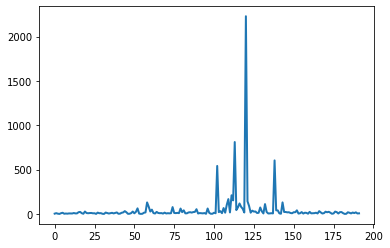

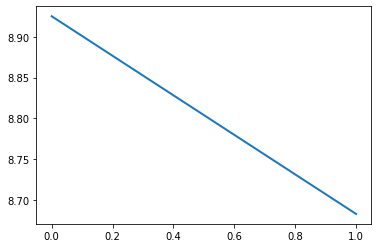

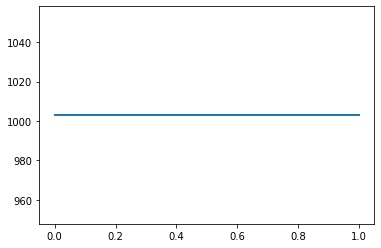

q_values are: [34.447742 67.64765  81.85701   7.092848 89.09329  53.45312 ] STATE LEN: 768
this action is QMAX: 4
branching now: 201 reward 0 action 4
q_values are: [26.546108 33.1552   37.899742  9.394145 46.53031  27.923756] STATE LEN: 768
this action is QMAX: 4
branching now: 202 reward 0 action 4
q_values are: [24.020142 37.00302  34.98214  10.210201 44.16746  29.950485] STATE LEN: 768
this action is QMAX: 4
branching now: 203 reward 0 action 4
q_values are: [23.4268   31.892868 38.80929   9.892746 43.51177  24.563202] STATE LEN: 768
this action is QMAX: 4
branching now: 204 reward 0 action 4
branching now: 205 reward 0 action 5
branching now: 206 reward 0 action 3
branching now: 207 reward 0 action 2
branching now: 208 reward 0 action 3
branching now: 209 reward 0 action 1
q_values are: [39.019257 73.13335  84.79439   7.093054 99.19917  59.960094] STATE LEN: 768
this action is QMAX: 4
branching now: 210 reward 0 action 4
q_values are: [33.074913  54.97531   64.1167     1.7479115 9

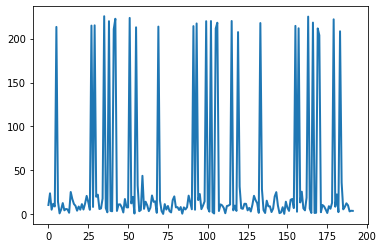

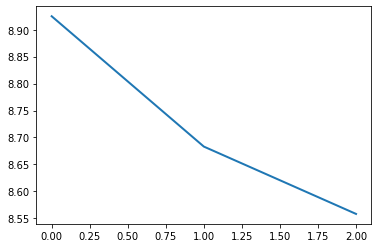

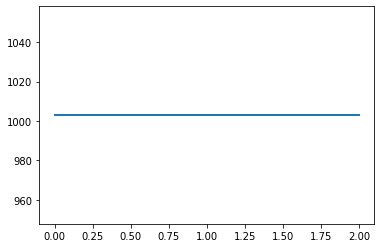

q_values are: [72.00787  23.595047 50.08956  27.172935 46.38138  32.21257 ] STATE LEN: 768
this action is QMAX: 0
branching now: 401 reward 0 action 0
branching now: 402 reward 0 action 4
q_values are: [61.71759  22.341932 43.462097 26.080853 44.031494 30.725254] STATE LEN: 768
this action is QMAX: 0
branching now: 403 reward 0 action 0
branching now: 404 reward 0 action 4
branching now: 405 reward 0 action 1
q_values are: [141.90079   41.94869   99.1621    33.42595   85.554214  64.72797 ] STATE LEN: 768
this action is QMAX: 0
branching now: 406 reward 0 action 0
q_values are: [46.95748  23.738697 33.740158 20.97776  34.821106 25.627283] STATE LEN: 768
this action is QMAX: 0
branching now: 407 reward 0 action 0
branching now: 408 reward 0 action 1
branching now: 409 reward 0 action 5
branching now: 410 reward 0 action 3
q_values are: [129.24643   32.379574  93.367516  41.62631   71.242676  54.46499 ] STATE LEN: 768
this action is QMAX: 0
branching now: 411 reward 0 action 0
branching n

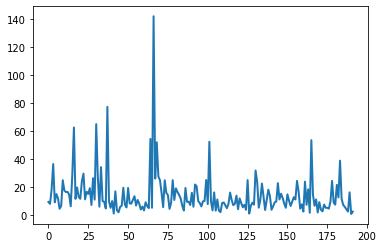

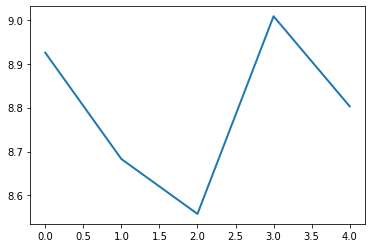

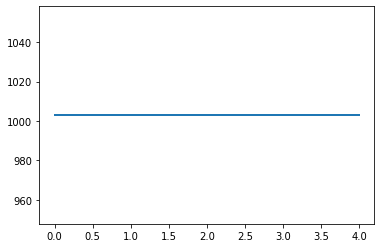

branching now: 601 reward 0 action 3
branching now: 602 reward 0 action 1
q_values are: [ 29.236826   42.056976   42.57596    42.163418  108.0482     10.7612095] STATE LEN: 768
this action is QMAX: 4
branching now: 603 reward 0 action 4
q_values are: [ 34.311058  45.183243  42.671814  42.471832 107.40297   12.113537] STATE LEN: 768
this action is QMAX: 4
branching now: 604 reward 0 action 4
q_values are: [28.034317 42.663155 39.133003 42.30147  96.406784 14.454163] STATE LEN: 768
this action is QMAX: 4
branching now: 605 reward 0 action 4
branching now: 606 reward 0 action 3
q_values are: [22.090141 43.460403 37.43023  42.146553 94.16832  13.630494] STATE LEN: 768
this action is QMAX: 4
branching now: 607 reward 0 action 4
branching now: 608 reward 0 action 1
branching now: 609 reward 0 action 4
q_values are: [ 47.817265  79.64183   75.67775   57.87173  203.80121   15.658482] STATE LEN: 768
this action is QMAX: 4
branching now: 610 reward 0 action 4
q_values are: [ 37.60697   68.817764

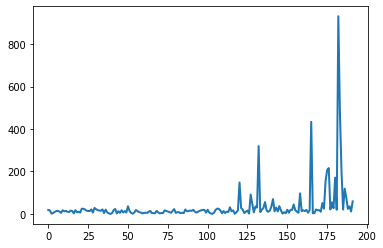

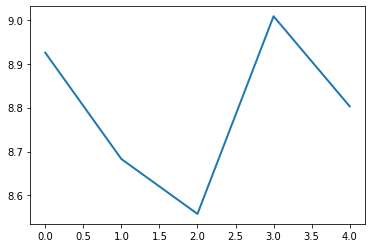

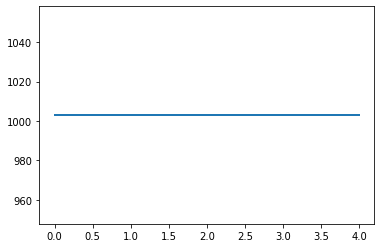

branching now: 801 reward 0 action 3
branching now: 802 reward 0 action 5
q_values are: [59.994667 44.240517 46.52234  76.91717  -5.031108 68.30966 ] STATE LEN: 768
this action is QMAX: 3
branching now: 803 reward 0 action 3
q_values are: [291.37152  114.43259    7.962331 215.46213   45.570343 163.09082 ] STATE LEN: 768
this action is QMAX: 0
branching now: 804 reward 0 action 0
branching now: 805 reward 0 action 5
q_values are: [311.7785  151.0105   16.84718 252.92311 -82.68876 199.29893] STATE LEN: 768
this action is QMAX: 0
branching now: 806 reward 0 action 0
branching now: 807 reward 0 action 2
q_values are: [406.82224   99.09305   57.80279  252.29393  115.585144 277.87473 ] STATE LEN: 768
this action is QMAX: 0
branching now: 808 reward 0 action 0
branching now: 809 reward 0 action 5
branching now: 810 reward 0 action 0
branching now: 811 reward 0 action 2
q_values are: [266.12952   117.046265    9.905936  220.47498     5.2844133 144.76617  ] STATE LEN: 768
this action is QMAX: 0

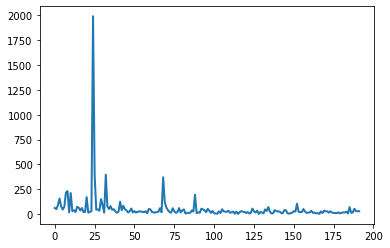

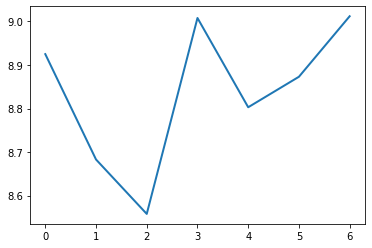

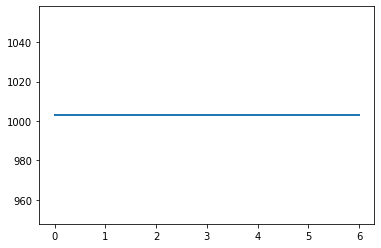

q_values are: [114.18663  165.62825  127.068054  80.83748  493.4929   112.94281 ] STATE LEN: 768
this action is QMAX: 4
branching now: 1001 reward 0 action 4
q_values are: [118.770294 159.83018  147.3262   101.88401  530.1688   130.90268 ] STATE LEN: 768
this action is QMAX: 4
branching now: 1002 reward 0 action 4
q_values are: [119.83243 138.83961 135.2546  104.71019 506.1148  121.05437] STATE LEN: 768
this action is QMAX: 4
branching now: 1003 reward 0 action 4
branching now: 1004 reward 0 action 5
q_values are: [ 59.55485   77.89586   64.81099   41.327034 213.93445   61.78373 ] STATE LEN: 768
this action is QMAX: 4
branching now: 1005 reward 0 action 4
branching now: 1006 reward 0 action 1
branching now: 1007 reward 0 action 3
branching now: 1008 reward 0 action 0
q_values are: [ 44.67627   56.361015  48.52504   37.199535 133.30345   42.08382 ] STATE LEN: 768
this action is QMAX: 4
branching now: 1009 reward 0 action 4
q_values are: [105.38153 131.4885  120.11482  93.7225  469.82178

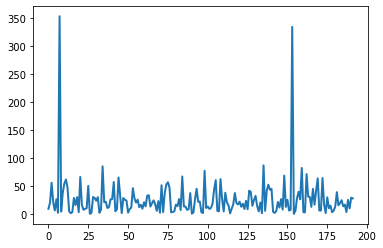

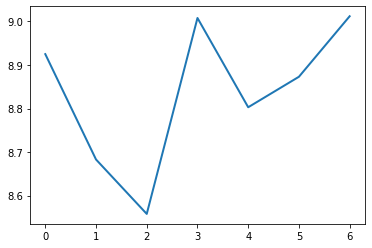

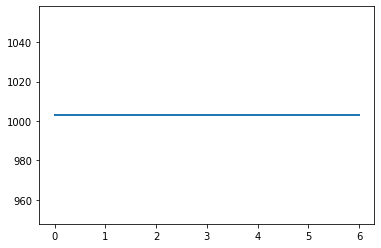

q_values are: [142.65605  136.45592  177.11388  141.27641  351.24496  125.361855] STATE LEN: 768
this action is QMAX: 4
branching now: 1201 reward 0 action 4
branching now: 1202 reward 0 action 0
q_values are: [ 70.13548  79.20436  88.87738  77.67442 185.03186  68.64319] STATE LEN: 768
this action is QMAX: 4
branching now: 1203 reward 0 action 4
q_values are: [137.50542 137.53217 167.43779 126.87694 358.29114 136.79646] STATE LEN: 768
this action is QMAX: 4
branching now: 1204 reward 0 action 4
branching now: 1205 reward 0 action 1
q_values are: [ 56.88404   52.198837  64.28963   58.976482 121.868576  43.629246] STATE LEN: 768
this action is QMAX: 4
branching now: 1206 reward 0 action 4
branching now: 1207 reward 0 action 3
q_values are: [213.30692 189.96675 275.273   217.08482 569.3473  193.95424] STATE LEN: 768
this action is QMAX: 4
branching now: 1208 reward 0 action 4
q_values are: [ 63.24398   64.795715  75.37417   63.22037  154.58131   58.89543 ] STATE LEN: 768
this action is QM

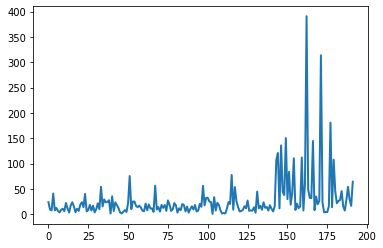

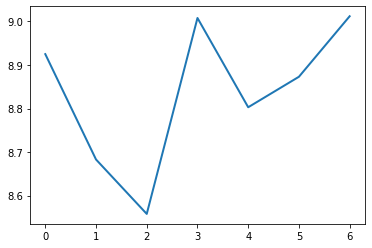

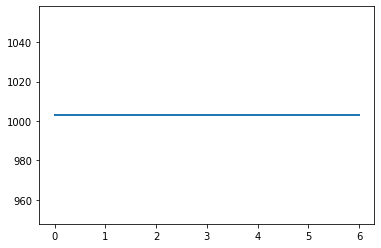

q_values are: [ 34.85326   66.24241   46.926758  88.37668  151.9098    43.413734] STATE LEN: 768
this action is QMAX: 4
branching now: 1401 reward 0 action 4
branching now: 1402 reward 0 action 2
q_values are: [ 35.615105  49.062294  40.94084   66.227516 120.96481   35.277805] STATE LEN: 768
this action is QMAX: 4
branching now: 1403 reward 0 action 4
branching now: 1404 reward 0 action 1
branching now: 1405 reward 0 action 3
branching now: 1406 reward 0 action 0
q_values are: [ 38.705097  64.14352   44.8725    73.204926 151.58855   42.36271 ] STATE LEN: 768
this action is QMAX: 4
branching now: 1407 reward 0 action 4
q_values are: [ 44.726154  65.36102   48.503628  63.620125 145.42738   46.930275] STATE LEN: 768
this action is QMAX: 4
branching now: 1408 reward 0 action 4
q_values are: [ 34.06374  54.03653  49.56871  99.47159 144.0153   41.85022] STATE LEN: 768
this action is QMAX: 4
branching now: 1409 reward 0 action 4
q_values are: [ 31.705664  53.6847    45.808598  93.74212  133.8

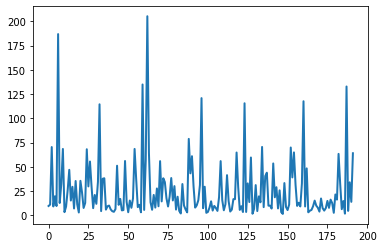

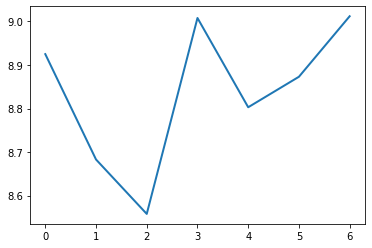

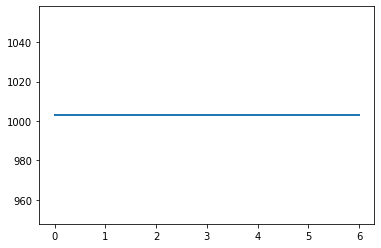

q_values are: [ 68.523796  50.332783  69.494385  13.14133  122.80412   44.46369 ] STATE LEN: 768
this action is QMAX: 4
branching now: 1601 reward 0 action 4
branching now: 1602 reward 0 action 5
branching now: 1603 reward 0 action 5
q_values are: [ 81.84342   62.832203  88.79968    8.604829 164.08884   57.447212] STATE LEN: 768
this action is QMAX: 4
branching now: 1604 reward 0 action 4
q_values are: [ 85.254684  62.7176    93.71509    9.142504 160.32675   58.22529 ] STATE LEN: 768
this action is QMAX: 4
branching now: 1605 reward 0 action 4
q_values are: [ 74.052666  53.15596   81.463     12.096473 144.20483   48.923943] STATE LEN: 768
this action is QMAX: 4
branching now: 1606 reward 0 action 4
q_values are: [ 78.82017   56.97165   84.92964    4.941595 156.12961   51.29873 ] STATE LEN: 768
this action is QMAX: 4
branching now: 1607 reward 0 action 4
branching now: 1608 reward 0 action 2
q_values are: [323.30692  226.15054  362.30798  -10.364685 709.2249   207.3446  ] STATE LEN: 768

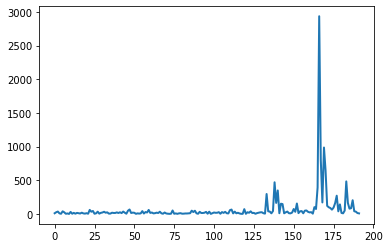

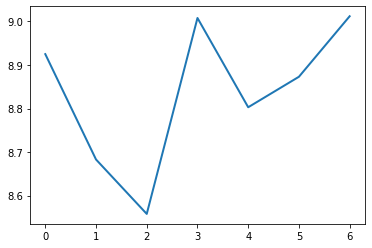

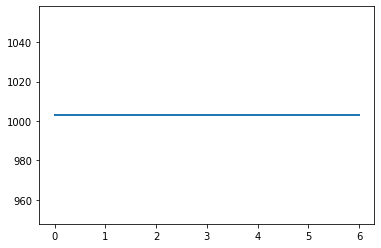

q_values are: [  18.19405   339.74      102.201775 -249.45605   576.0033    142.08067 ] STATE LEN: 768
this action is QMAX: 4
branching now: 1801 reward 0 action 4
q_values are: [-230.5586    401.67133  -201.0687    -26.288887  600.4075    156.95534 ] STATE LEN: 768
this action is QMAX: 4
branching now: 1802 reward 0 action 4
q_values are: [-167.32191  206.22092 -186.10019  -32.31788  591.56165  133.63557] STATE LEN: 768
this action is QMAX: 4
branching now: 1803 reward 0 action 4
q_values are: [-235.18495   147.76447  -320.13837    -8.319572  530.10004   148.0694  ] STATE LEN: 768
this action is QMAX: 4
branching now: 1804 reward 0 action 4
branching now: 1805 reward 0 action 2
branching now: 1806 reward 0 action 4
q_values are: [ 396.0703  1076.5518   368.84164 -610.5611   213.58275  826.0003 ] STATE LEN: 768
this action is QMAX: 1
branching now: 1807 reward 0 action 1
q_values are: [-10.5326     41.314426   -2.6850872  30.45155   148.13535    25.104502 ] STATE LEN: 768
this action i

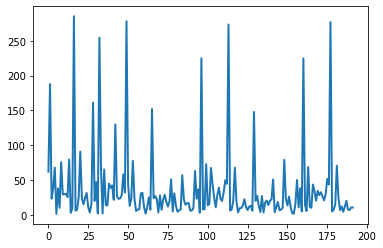

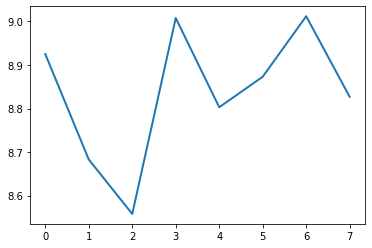

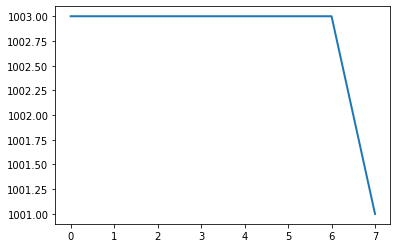

branching now: 2001 reward 0 action 4
branching now: 2002 reward 0 action 4
q_values are: [ 24.322441  41.93459   42.88626   79.562874 123.49128   38.07541 ] STATE LEN: 768
this action is QMAX: 4
branching now: 2003 reward 0 action 4
branching now: 2004 reward 0 action 0
q_values are: [ 25.532131  83.38225   74.70116  176.9753   287.3859    76.44864 ] STATE LEN: 768
this action is QMAX: 4
branching now: 2005 reward 0 action 4
branching now: 2006 reward 0 action 3
q_values are: [ 34.372215  78.9594    77.41403  167.37878  279.388     83.90872 ] STATE LEN: 768
this action is QMAX: 4
branching now: 2007 reward 0 action 4
q_values are: [ 17.762684  55.13896   48.4886    98.69032  180.32018   43.64747 ] STATE LEN: 768
this action is QMAX: 4
branching now: 2008 reward 0 action 4
q_values are: [ 20.929716  47.587494  52.17615  102.2063   158.71397   51.476555] STATE LEN: 768
this action is QMAX: 4
branching now: 2009 reward 0 action 4
q_values are: [ 19.038654  47.087     44.79613  104.25388 

PulpSolverError: ignored

In [ ]:
count_global = 0 
count_branching = 0 
overall_reward_list = []
tsp_id_list = []
exploration_rate1 = 0.9 # initial exploration
exploration_delta = 0.005

for m in range(10): 

  max_num_of_episodes = (20 - 2*m) -1  

  if m >= 2:
    exploration_rate = exploration_rate1/m # go back to full exploration per loop
  else: 
    exploration_rate = exploration_rate1

  print('LOOP:', m)

  for j in range(len(train_tsp_list)):
      
      #pick TSP and init
      tsp_id = train_tsp_list[j][0]
      data_name = train_tsp_list[j][1]
      problem1 = act.init_prob(tsp_id, data_name, 0, 'continuous')      
      initial_objective = problem1.objective_val
      prev_objective = initial_objective

      print("Running with TSP:", tsp_id, "Initial EXP Rate:", exploration_rate, "Iteration:", j)

      count_complete = 0  

      # ADD VALID INEQUALITIES A BIT
      ineq_action = 0
      constraint_count = 0
      change_flag = 1
      con_limit = 200 # constraint limit

      while change_flag == 1 and constraint_count <= con_limit and ineq_action <= max(20, problem1.n_nodes/10): 
        count_global = count_global + 1
        ineq_action = ineq_action + 1 
        problem1, change_flag, constraint_count = add_valid_ineq(problem1, constraint_count)

      # plot_graph(problem1) # show the initial solution graph once
      problem2 = deepcopy(problem1) # keep copy to return back to beginning
      print('added subtours:', count_global)
      prev_objective = problem1.objective_val

      # LOOP FOR BRANCHING 
      for k in range(max_num_of_episodes):
        print('TSP:', tsp_id, 'Iteration:', k, 'EXP rate:', exploration_rate)  
        branch_ever_flag = 0
        change_flag = 0
        action_count = 0
        problem1 = deepcopy(problem2)
        reward = 0

        if exploration_rate > 0.1:
            exploration_rate = exploration_rate - exploration_delta

        while problem1.complete_flag == 0 and action_count <= max(30, problem1.n_nodes/1.7): # means no room for branching
          count_global = count_global + 1
          action_count = action_count + 1        

          # KEEP ADDING VALID INEQUALITIES 
          prev_objective = problem1.objective_val
          problem1, change_flag, constraint_count = add_valid_ineq(problem1, constraint_count)
          
          branch_flag = check_branch(problem1)
                  
          if change_flag == 0 and branch_flag == 0 and problem1.complete_flag == 0:
            # back to beginning
            print('break while loop')
            break  # break while loop

          elif branch_flag == 1: 
            # START BRANCHING
            branch_ever_flag = 1
            count_branching = count_branching + 1
            state, node, connection, regret = define_state(problem1, GAT3, GCN1)

            # pick an action
            action = agent.act(state, exploration_rate)
            

            # take the action    
            prev_objective = problem1.objective_val

            problem1 = act.add_branch(problem1, node, connection, regret, action)
            problem1.solve_lp_relax()
            problem1.graph = problem1.create_graph()
            problem1.check_if_complete()
            next_state = define_next_state(problem1, node, connection, regret, GAT3, GCN1)

            #calculate reward
            reward =  calculate_reward(problem1, initial_objective, prev_objective)
            print('branching now:', count_branching, 'reward', reward, 'action', action)

            # store S-A-R-NS
            if reward <= 0:
              random1 = random.random() 
              if random1 <= 0.7:
                agent.store(state, action, reward, next_state, problem1.complete_flag)

          # train NN if it gets enough number of obs    
          if len(agent.memo) > batch_size and count_branching% (batch_size*3) == 0: 
            loss_list = agent.retrain(batch_size, loss_list)
            print('number of cumulated obs:', len(agent.memo))

          if len(agent.memo) >= 49900: 
            print('Memory is over')
            agent.memo = deque(maxlen=50000)
                      
          if count_branching%200 == 0 and count_branching > 0:
            # keep saving models
            th.save(agent.q_network.state_dict(), "GCN_QNET_"+MODEL_TAG+".pth.tar")
            th.save(agent.target_network.state_dict(), "GCN_TARGETNET_"+MODEL_TAG+".pth.tar")
            df1 = pd.DataFrame() 
            df1['tsp_id'] = tsp_id_list
            df1['reward'] = overall_reward_list
            pd.DataFrame(df1).to_csv("ALLINFO_"+MODEL_TAG+".csv")

            plt.plot(loss_list, linewidth=2.0)
            plt.show()
            plt.plot(overall_reward_list, linewidth=2.0)
            plt.show()
            plt.plot(tsp_id_list, linewidth=2.0)
            plt.show()
            loss_list = [] # empty loss
          
          # align if the tour is complete
          if branch_ever_flag == 1 and problem1.complete_flag == 1:
            # align networks
            agent.align_target_model()
            print('aligning networks')
            count_complete = count_complete + 1 
            reward = calculate_reward(problem1, initial_objective, prev_objective)
            overall_reward_list.append(reward)
            tsp_id_list.append(tsp_id)
            next_state = define_next_state(problem1, node, connection, regret, GAT3, GCN1)
            print('completed now!')
            print('FINAL STATE, branch count:', count_branching, 'reward', reward, 'action', action)
            # store it with the final SARSA observed 
            agent.store(state, action, reward, next_state, problem1.complete_flag)
            print('TSP_ID:', tsp_id, 'iter', j, 'inner action count:', action_count, 'COMPLETE_COUNT:', count_complete, 'REWARD', reward, 'BF:', branch_ever_flag, 'EXP RATE', exploration_rate)
                
          elif count_global > 0 and count_global%(batch_size*4)== 0: # align networks after X iterations
            agent.align_target_model()
            print('aligning networks')


In [ ]:
th.save(agent.q_network.state_dict(), "GCN_QNET_"+MODEL_TAG+".pth.tar")
th.save(agent.target_network.state_dict(), "GCN_TARGETNET_"+MODEL_TAG+".pth.tar")
df1 = pd.DataFrame() 
df1['tsp_id'] = tsp_id_list
df1['reward'] = overall_reward_list
pd.DataFrame(df1).to_csv("ALLINFO_"+MODEL_TAG+".csv")     
        
files.download("GCN_QNET_"+MODEL_TAG+".pth.tar") 
files.download("GCN_TARGETNET_"+MODEL_TAG+".pth.tar")
files.download("ALLINFO_"+MODEL_TAG+".csv")